# Data exploration & preprocessing

## Imports & load data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
import string
import spacy
from pandas import option_context
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, classification_report, RocCurveDisplay, multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve, LearningCurveDisplay, ShuffleSplit
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from yellowbrick.classifier.rocauc import roc_auc

data_root_folder='../data'
data_images_root_folder='../data/images'
nlpfr = spacy.load('fr_core_news_sm')

In [3]:

def load_data():
    x_train_df=pd.read_csv(f'{data_root_folder}/X_train_update.csv', index_col=0)
    #x_test_df=pd.read_csv(f'{data_root_folder}/X_test_update.csv', index_col=0)
    y_train_df=pd.read_csv(f'{data_root_folder}/Y_train_CVw08PX.csv', index_col=0)
    return pd.concat([x_train_df,y_train_df], axis=1 )
    
data= load_data()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB
None


* Columns types are relevant
* Data size is relevant for Machine Learning
* 'prdtypecode' is the target variable
* 'designation' & 'description' are the features
* 'productid' & 'imageid' are not relevant for the ML program, only for data exploration when it comes to linking the text to the image
* For the suggested X_test, Y_test is missing, the test data will be generated from the train data 

## Missing & duplicated

35% of 'description' column values are missing & 60% of 'description' are distinct

### Missing images ?

In [3]:
notfound=False
for index, row in data.iterrows():
    imgid = row['imageid']
    prdid = row['productid']
    try:
        mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
    except FileNotFoundError as error:  
       notfound=True
       print('Image not found', error)
if not notfound:
    print('No image is missing')

No image is missing


### Duplicated values

In [ ]:
data_descnotna=data[-data.description.isna()]
data_desc_dup=data_descnotna[data_descnotna.duplicated(['description'])].groupby('description').agg(count=('prdtypecode', 'size'),prdtypecodes=('prdtypecode',lambda x: str(x.unique()))).sort_values(by=['count'], ascending=False).query('count>30')
display(data_desc_dup)

- Most of duplicated values are related to one type, which sets a corrolation between that could be useful in predicting the label
- The duplicated value '\<br />' can be deleted as it doesn't bring any semantic
- The duplicated value '...Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres'...' can be deleted as well.

## Product types data exploration

### Distribution

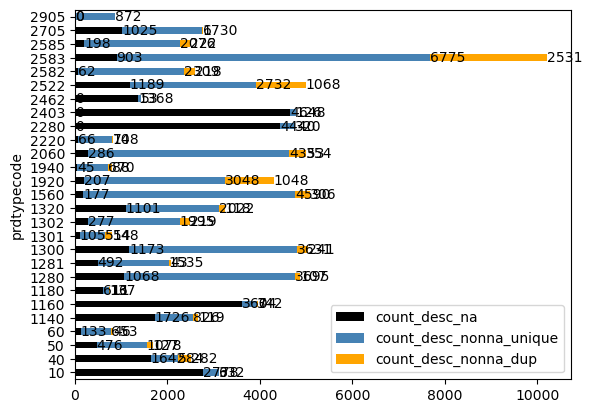

In [4]:
data_byprdtype_na=data.groupby('prdtypecode', group_keys=True).agg(count_desc_na=('description',lambda x: x.isna().sum()), count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))
ax1=data_byprdtype_na.plot.barh(stacked=True, color=['black', 'steelblue', 'orange'])
ax1.bar_label(ax1.containers[0], labels=data_byprdtype_na['count_desc_na'])
ax1.bar_label(ax1.containers[1], labels=data_byprdtype_na['count_desc_nonna_unique'])
ax1.bar_label(ax1.containers[2], labels=data_byprdtype_na['count_desc_nonna_dup'])
plt.show();

- Product types are not evenly distributed, 2583 is an outlier 
- Need to rebalance the data, by : 
    * For types with highest counts, deleting rows with description = NA values & replacing duplicates
    * Some product types have small amount of relevant 'description', for those a strategy might be relying on the 'designation'
    * Then rebalance the rest following guidelines [here](https://medium.com/@dlikhitha99/all-methods-for-balancing-imbalanced-data-decfe1f4048d)




### Guess what's behind the product type code ?

The goal of following routine is to : 

* Identifiy to what extent the 'designation' & 'description' content are capable to relate to a product type
* What kind of data cleaning should be carried out to make text data the most relevant
* Determine the semantic behind the product type code by displaying random pictues and top keywords for each product type code, it would help in better human interpretation of results during the model experimentation.


In [ ]:
bytypecode = data.groupby('prdtypecode')
nsamples=20

final_stopwords_list = list(fr_stop) + list(en_stop)
max_features=5
coun_vect1 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)
coun_vect2 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)


for code, frame in bytypecode:
    print(f"First {nsamples} entries for type {code!r}")
    fig, axs = plt.subplots(1, nsamples, figsize=(30, 10))
    frame_samples=frame.head(nsamples)
    display(frame_samples[['designation', 'description', 'prdtypecode']])
    for ax, (index, row) in zip(axs,frame_samples.iterrows()):
        imgid = row['imageid']
        prdid = row['productid']
        img = mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
        imgplot = ax.imshow(img)
        ax.axis('off')
    plt.show()

    # Text count vectorizer on the product type data frame
    print('Before cleaning')
    count_matrix_desi = coun_vect1.fit_transform(frame['designation'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame['designation']+frame['description'].fillna(''))
    print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', coun_vect2.get_feature_names_out())

    
    print('After cleaning')
    to_ignore=['cm','mm','taille','aaa','aaaa','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','blanc','gris','noir']
    frame_cleaned=frame.fillna('')\
        .replace(r'<.*?>','', regex=True)\
          .replace(r'\d+','', regex=True)\
            .replace(r'.*Attention !!! Ce produit est un import.*','', regex=True)\
            .replace(re.compile(r'\[Import Allemand\]'),'', regex=True)\
              .replace({f'(?i){word}': '' for word in to_ignore}, regex=True)
    count_matrix_desi = coun_vect1.fit_transform(frame_cleaned['designation'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame_cleaned['designation']+frame_cleaned['description'])
    print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', coun_vect2.get_feature_names_out())
    
    print("-----------------------------------------------------------------------")


Combining 'designation' with 'description' seems to give better results in term of identifying the features related to the product type  

Tokens that can be ignored:
* english and french stop words
* ponctuation
* dimension vocab: cm, mm, hauteur, etc
* colors vocab: blanc, girs, etc.
* HTML markdown tags
* numerics
* lemmatization: process of reducing a token to its lemma

From the data assessment above & search made in rakuten website, following product types labels are identified as related to the existing product type codes.

In [14]:
map_prdtypecode_guess={10:'Livres/Livres anciens ?', 
                       40:'Jeux vidéo', 
                       50:'Jeux vidéo/Accessoires', 
                       60:'Consoles', 
                       1140:'Goodies/Figurines', 
                       1160:'Goodies/Cartes de jeux', 
                       1180:'Jouets enfant/occasion ?',
                       1280:'Jouets enfant',
                       1281:'Jouets enfant/occasion ?',
                       1300: 'Modélisme',
                       1301: 'Puériculture',
                       1302: 'Puériculture autre ?',
                       1320: 'Puériculture autre ?',
                       1560: 'Mobilier',
                       1920: 'Coussin Décoratif',
                       1940: 'Alimentation',
                       2060: 'Décoration',
                       2220: 'Aminalerie',
                       2280: 'Revues et magazines anciens',
                       2403: 'Lots de Livres et de Revues',
                       2462: 'Lots de consoles et jeux vidéo',
                       2522: 'Fournitures Papeterie',
                       2582: 'Mobilier de Jardin',
                       2583: 'Entretien piscine & spa',
                       2585: 'Outillage de jardin',
                       2705: 'Livres/Littérature',
                       2905: 'Jeux Vidéo/PC'}

## Text data preprocessing

In [4]:
# Takes 10min with lemma
to_ignore=['cm','mm','taille','aaa','aaaa','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','anglais','blanc','gris','noir']

def camel_split(s):
    if s=='' :return s
    result = [s[0]] 
    for char in s[1:]:
        if char.isupper():
            result.extend([' ', char])
        else:
            result.append(char)
    return ''.join(result)

def clean_text_1(c):
    c= re.sub(r'.*Attention !!! Ce produit est un import.*', '', c)
    c= re.sub(re.compile(r'\[Import Allemand\]'), '', c)
    c= re.sub(r'<.*?>', ' ', c)
    #c = camel_split(c)
    c = c.lower()
    c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, nlpfr.Defaults.stop_words)))), '', c)
    c= re.sub('[%s]' % re.escape(string.punctuation), '', c)
    c= re.sub(re.compile(r'\b(?:{})\b'.format('|'.join(map(re.escape, to_ignore)))), '', c)
    c= re.sub(r'\d', '', c)
    c=' '.join([word for word in c.split() if len(word) >=3])
    #ignored as takes time consuming
    #c=' '.join([token.lemma_ for token in list(nlpfr(c)) if (token.is_stop==False)])
    return c

def clean_data(data=data, cleaner=clean_text_1):
  data_cleaned = data[['designation','description','prdtypecode']].fillna('')
  txt_data_origin=data_cleaned["designation"].str.cat(data_cleaned["description"], sep = " ")
  data_cleaned['desi_desc_c'] = txt_data_origin.apply(lambda x:cleaner(x))
  result=pd.DataFrame(
    dict(
        text=data_cleaned["desi_desc_c"],
        target=data_cleaned["prdtypecode"]
    ))
  return (result, txt_data_origin)

data_cleaned,txt_data_origin = clean_data()

In [5]:
with option_context('display.max_colwidth', 400):
  display(pd.DataFrame({'desi_desc_before':txt_data_origin,'desi_desc_after':data_cleaned.text}))

,desi_desc_before,desi_desc_after
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,olivia personalisiertes notizbuch seiten punktraster din rosendesign
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,journal arts art marche salon art asiatique paris jacques barrere francois perrier reforme ventes encheres publiques sna fete ans
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un su...,grand stylet ergonomique bleu gamepad nintendo wii speedlink pilot style pilot style touch pen marque speedlink stylet ergonomique gamepad nintendo wii confort optimal précision maximale gamepad wii grand stylet hautement ergonomique non parfaitement adapté main élégant livré support fixe adhésif arrière gamepad caractéristiques modèle speedlink pilot style touch pen bleu ref fabricant slbe co...
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),peluche donald europe disneyland marionnette doigt
4,La Guerre Des Tuques Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,guerre tuques luc ideacute grandeur veut organiser jeu guerre boules neige arranger ecirctre vainqueur incontesteacute sophie mecirc chambarde plans
...,...,...
84911,The Sims [ Import Anglais ],the sims
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x 0.90m <b>Description complète :</b><br />Kit piscine hors-sol Toi PIEDRA GRIS ronde Ø 3.50m hauteur 0.90m. Parois acier liner 30/100eme uni bleu revêtement breveté exclusif imitant la pierre échelle profilés en PVC. Kit piscine complet.<br /><br /><b>Caractéristiques détaillées :</b><br />- Forme : Ronde<br />- Type : Kit piscine acier hors-sol<br...,kit piscine acier nevada déco pierre complète kit piscine sol piedra ronde parois acier liner eme uni bleu revêtement breveté exclusif imitant pierre échelle profilés pvc kit piscine complet caractéristiques détaillées forme ronde type kit piscine acier sol extérieures surface installation margelle utilisation sol capacité kit complet oui liner uni bleu fixation overlap margelles structure par...
84913,Journal Officiel De La Republique Francaise N° 46 Du 15/02/1871 - Changement D'adresses - Partie Officielle - Partie Non Officielle - Elections A L'assemblee Nationale - Ravitaillement De Paris - Nouvelles Etrangeres - Italie - Amerique.,journal officiel republique francaise changement adresses partie officielle partie non officielle elections assemblee nationale ravitaillement paris nouvelles etrangeres italie amerique
84914,Table Basse Bois De Récupération Massif Base Blanche 60x60x33cm <p>Cette table basse a un design unique et constituera un ajout intemporel à votre maison. Son dessus de table en bois massif est idéal pour ranger vos boissons panier de fruits ou objets décoratifs et sa base en acier solide ajoute à la robustesse de la table d&#39;appoint. La table basse est faite de bois de récupération massif ...,table basse bois récupération massif base blanche xxcm table basse design unique constituera ajout intemporel maison table bois massif idéal ranger boissons panier fruits objets décoratifs base acier solide ajoute robustesse table dappoint table basse faite bois récupération massif provenant solives planchers poutres soutien vieux bâtiments cours démolition composée types bois sesham bois rose...


## Text data exploration

<Axes: >

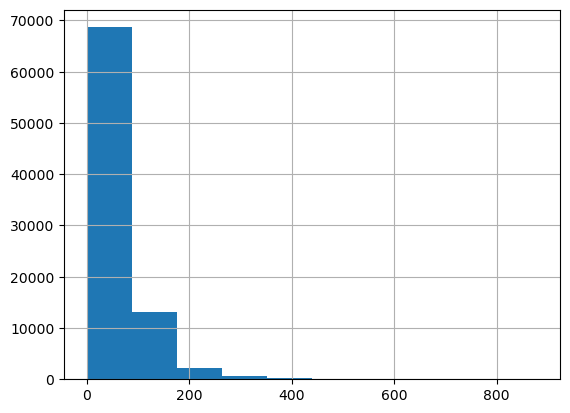

In [33]:
data_cleaned.txt.str.split().map(lambda x: len(x)).hist()

'designation' range from 10 to 250 characters and generally, it is between 75 to 100 characters

<Axes: >

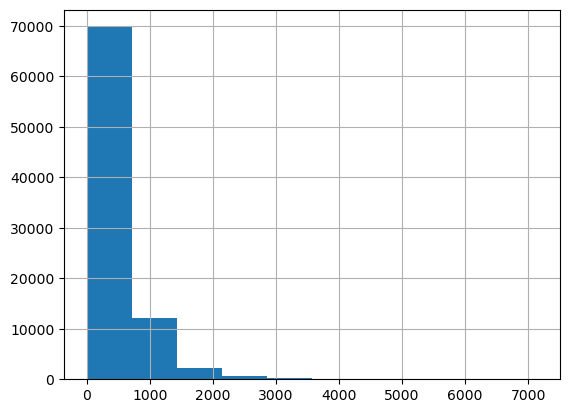

In [34]:
data_cleaned.txt.str.len().hist()

Number of words in designation ranges from 3 to 50 and mostly falls between 3 to 18 words.

/opt/anaconda3/envs/mle-rakuten/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/mle-rakuten/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: >

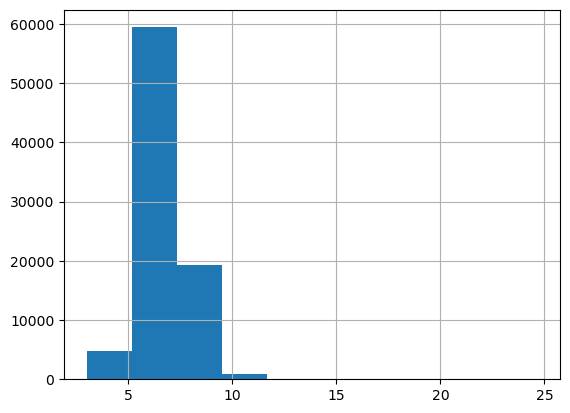

In [35]:
data_cleaned.txt.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

The average word length ranges between 2 to 8 with 5 being the most common length

# Features extraction

### Train test split

In [6]:
def do_train_test_split(data):
    return train_test_split(data.text,data.target, test_size=0.20, stratify=data.target, random_state=0)

X_train, X_test, y_train, y_test = do_train_test_split(data_cleaned)

### Document Term Matrix

In [ ]:
def output_vectorizer_features(data, vectorizer=CountVectorizer(), filename='dtm-feats.txt'):
    dtm = vectorizer.fit_transform(X_train)
    print('DTM shape', dtm.shape)
    dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
    dtm_df.index=data.index
    with open(filename, "w") as file:
        for c in dtm_df.columns:
            file.write(c+'\n')
output_vectorizer_features(X_train)

In [56]:
with option_context('display.max_colwidth', None):
    print(data[data.description.str.contains('(?i)aaabatteries', regex=True, na=False)]['description'])

16912    RemoteControl Walking Dinosaur Toy Fire Breathing Water Spray Christmas Gift BUFeature:Features: FlashingBattery OperatedSoundingWalkingsoundlightAgeRange: &gt; 3 years oldAnimals: DinosaursEnvironmental protection plastic &#43; electronic componentsColor box packagingProduct Size: 48 x 26 x 11cm.Requires 3 AAA batteries (Not Included) for the Dinosaur and 3 AAA batteriesfor the remote control (Not Included).This big dinosaur is an ideal gift for all kid dinosaur lovers with thepress of a button the dinosaur will come back to life roar and shake itshead!Start switchAs the dinosaurs moved forwardTheir claws and wings moved atthe same timeThe head and tail can be freely tilted.After a distance stop  tail  neck  swing  mouth closed.Fantastic Design with Mist Spray Function: The dinosaur can spray mist withWhite light every several seconds just like fire erupted from mouth. Thereis a built-in water case in head and you just need to use provided plasticbottle to fill water into the

# Model training

In [13]:
def load_and_clean_data(txt_cleaner):
    return clean_data(load_data(), txt_cleaner)

### Model evaluation

In [7]:
def test_model(model, X_test=X_test, y_test=y_test, roc_auc=True):    
    preds = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    print('accuracy: ', accuracy_score(y_test, preds), 
          'f1-score: ', f1_score(y_test, preds, average='macro'))
    
    if roc_auc : 
        print('roc-auc: ', roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
    print('classification_report: ')
    plt.subplots(figsize=(5, 8))
    crdf=pd.DataFrame(classification_report(y_test, preds, output_dict=True))
    sns.heatmap(crdf.iloc[:-1, :].T, annot=True,xticklabels=True, yticklabels=True, linewidth=0.1)
    #print(classification_report(y_test, preds))
    print('confusion matrices: ')
    cm = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm, y_test.unique())
    print('learning curve: ')
    plot_learning_curve(model, X_train, y_train)
    if roc_auc:
        print('ROC curves: ')
        plot_roc_curve(model, X_test, y_test)
    

def plot_learning_curve(model, X_train=X_train, y_train=y_train):
    common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "roc_auc",
    }
    LearningCurveDisplay.from_estimator(model, **common_params)
    plt.show()
    
def plot_roc_curve(model, X_test=X_test, y_test=y_test):
    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test)

def plot_confusion_matrix(confusion_matrix, class_names):
    df_cm = pd.DataFrame(confusion_matrix, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                annot_kws={'size': 10})
    plt.title('Actuals vs Predicted')
    plt.show()

In [8]:
def run_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, roc_auc=True):
    model.fit(X_train, y_train)
    test_model(model, X_test=X_test, y_test=y_test, roc_auc=roc_auc)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # With StratifiedKFold, the folds are made by preserving the percentage of samples for each class.
def run_models_cv(models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, roc_auc=True):
   
    scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']

    #  iterative loop print metrics from each model
    for name, model in tqdm(models.items()):
        print("Running cross-validation for model %s"%(name))
        result = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, verbose=3)
        print("%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%" 
            % (name, 
                result['test_accuracy'].mean()*100, 
                result['test_f1_macro'].mean()*100, 
                result['test_recall_macro'].mean()*100, 
                result['test_precision_macro'].mean()*100))
        print("Running the model %s"%(name))
        run_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, roc_auc=roc_auc)
        print("------------------------------------------------------------------------")



## Naive Bayes

In [7]:
mnb_pip = Pipeline([('vect', CountVectorizer()),('model', MultinomialNB())])

accuracy:  0.735456900612341 f1-score:  0.6878448531180964
roc-auc:  0.9402571638077094
classification_report: 
confusion matrices: 


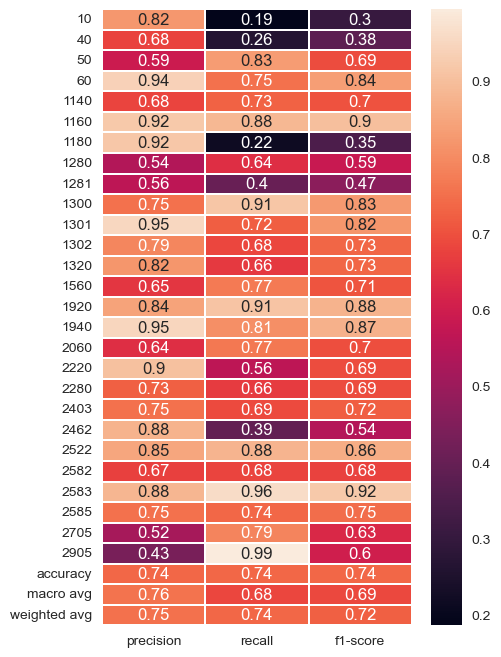

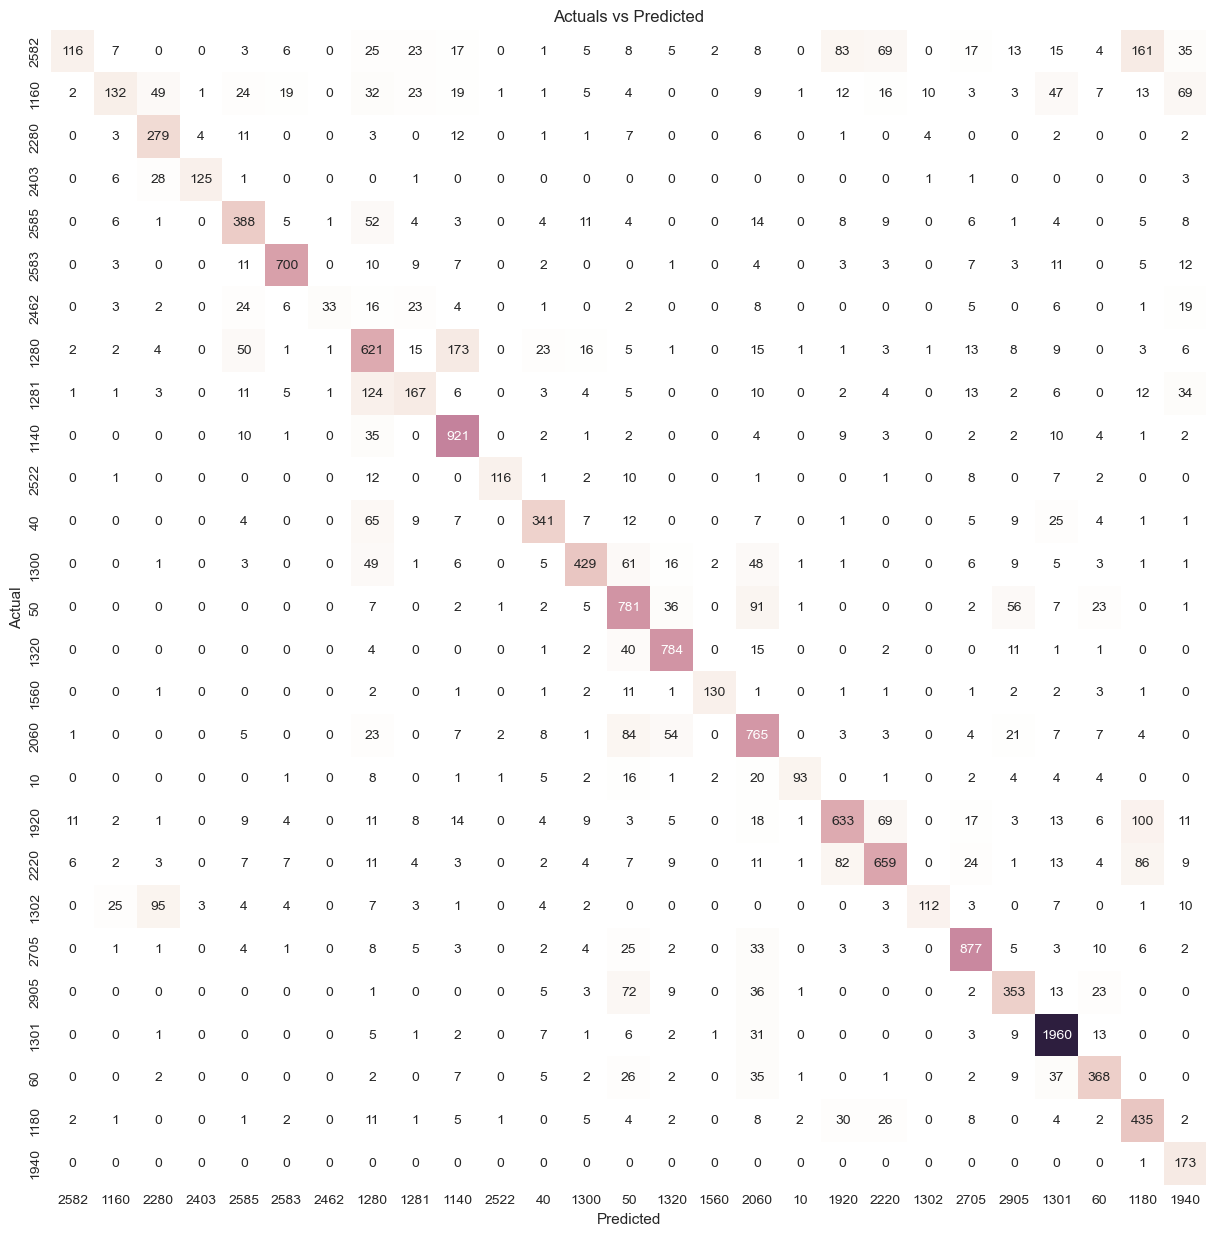

learning curve: 


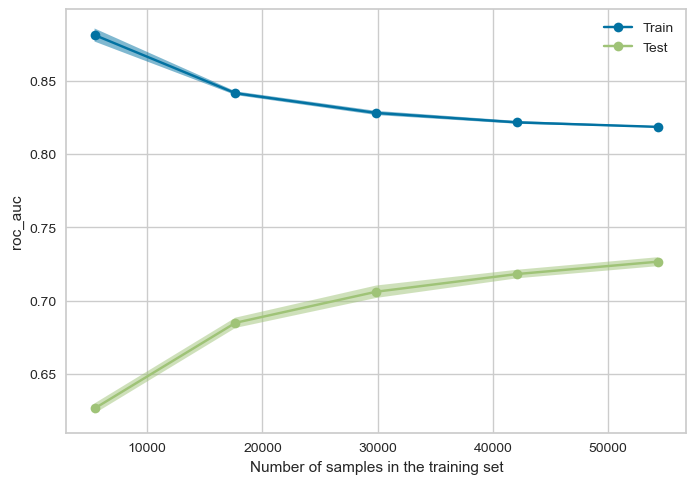

ROC curves: 


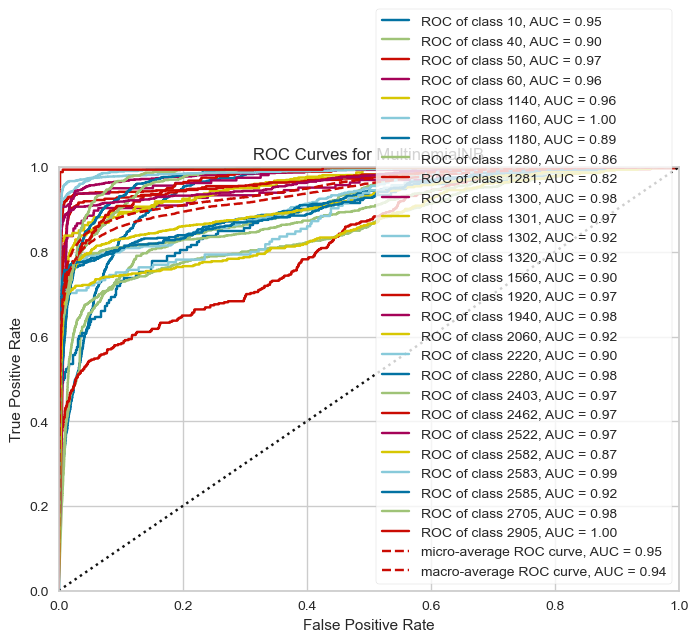

In [31]:
#run_models_cv({'Naive Batyes':mnb_pip})
test_model(mnb_pip)

In [32]:
cnb_pip = Pipeline([('vect', TfidfVectorizer()),('model', ComplementNB())])

  0%|          | 0/1 [00:00<?, ?it/s]

Running cross-validation for model Complement Naive Batyes
Complement Naive Batyes: Mean Accuracy = 74.54%; Mean F1-macro = 71.36%; Mean recall-macro = 71.11%; Mean precision-macro = 74.03%
Running the model Complement Naive Batyes
accuracy:  0.753061705134244 f1-score:  0.7222816985700268
roc-auc:  0.9760082981615986
classification_report: 
confusion matrices: 


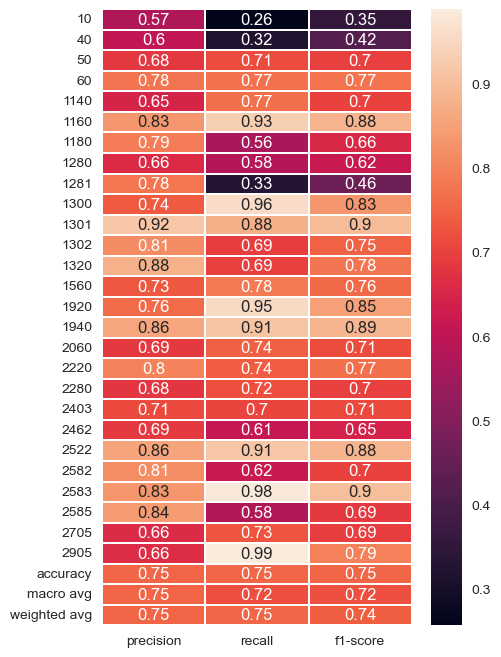

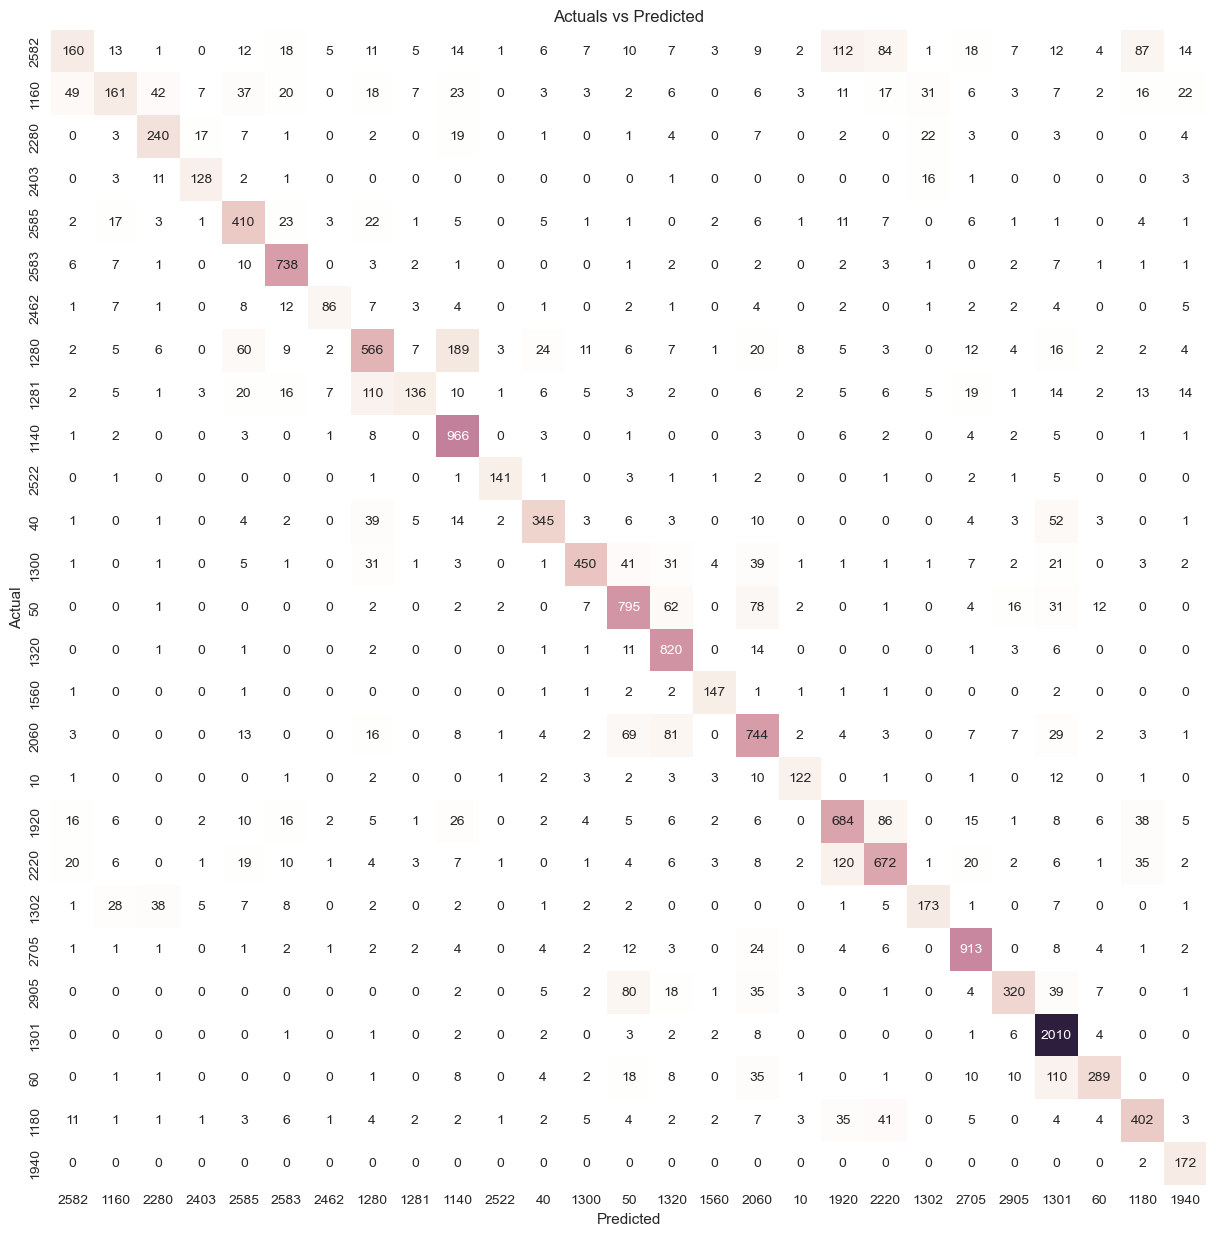

learning curve: 


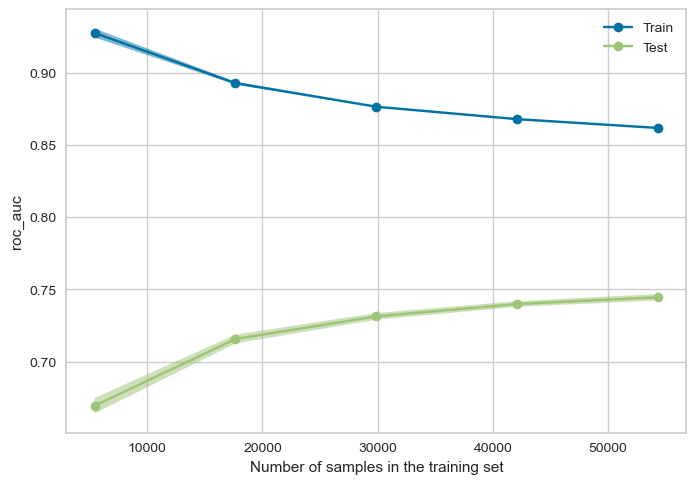

ROC curves: 


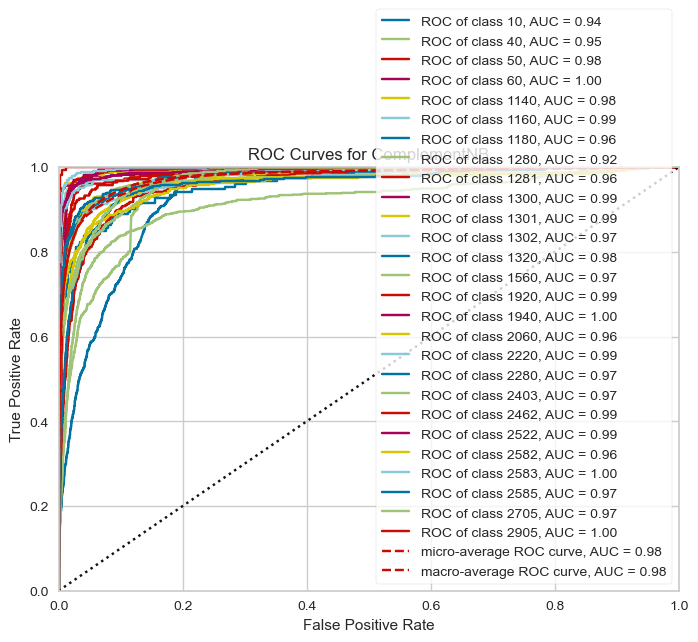

100%|██████████| 1/1 [00:28<00:00, 28.75s/it]

------------------------------------------------------------------------


In [33]:
run_models_cv({'Complement Naive Batyes':cnb_pip})

## Support Vector Machine (SVM)

In [9]:
svc_pip = Pipeline([('cvect', CountVectorizer()),('sscaler',StandardScaler(with_mean=False)), ('svc_model', LinearSVC(max_iter=150000, dual=False, random_state=42))])

In [10]:
run_models_cv({'Support Vector Machine':svc_pip}, roc_auc=False)

  0%|          | 0/1 [00:00<?, ?it/s]

Running cross-validation for model Support Vector Machine


## LogisticRegression

In [12]:
lr_pip = Pipeline([('cv', CountVectorizer()),('model', LogisticRegression( max_iter=1000))])

  0%|          | 0/1 [00:00<?, ?it/s]

Running cross-validation for model Logestic Regression
Logestic Regression: Mean Accuracy = 78.41%; Mean F1-macro = 77.07%; Mean recall-macro = 75.50%; Mean precision-macro = 79.41%
Running the model Logestic Regression
accuracy:  0.7949246349505417 f1-score:  0.7832341766019704
roc-auc:  0.9753778749047712
classification_report: 
confusion matrices: 


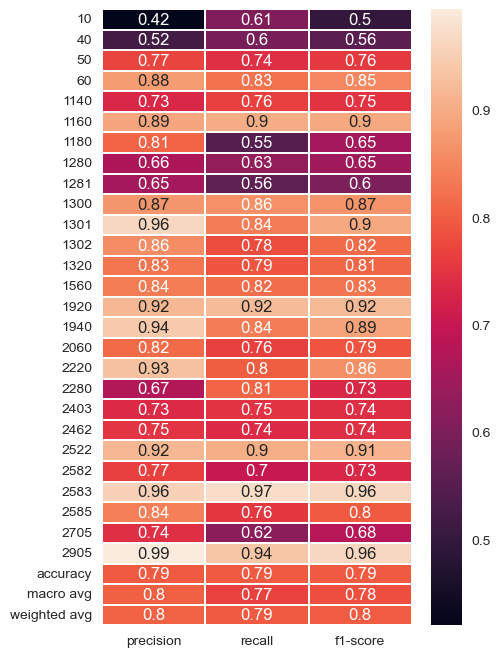

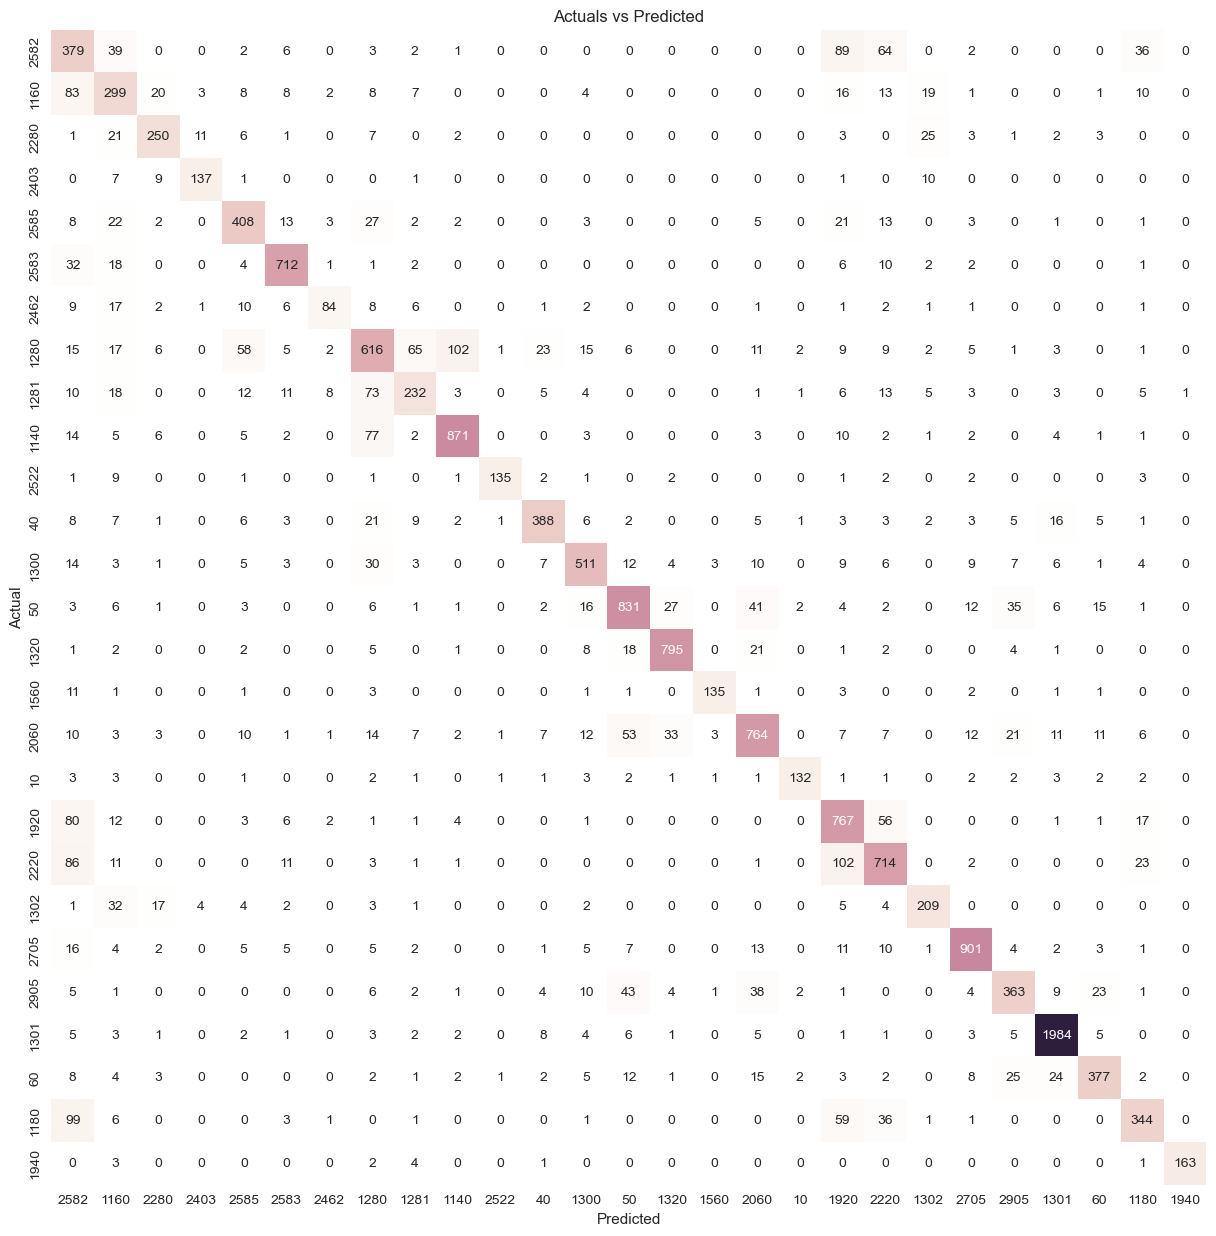

learning curve: 


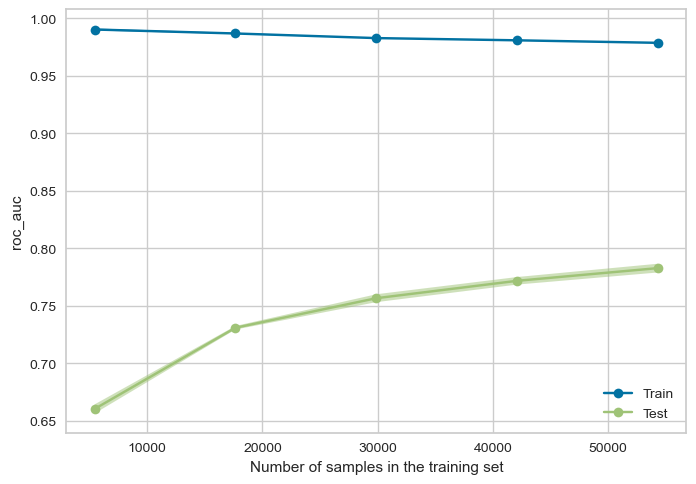

ROC curves: 


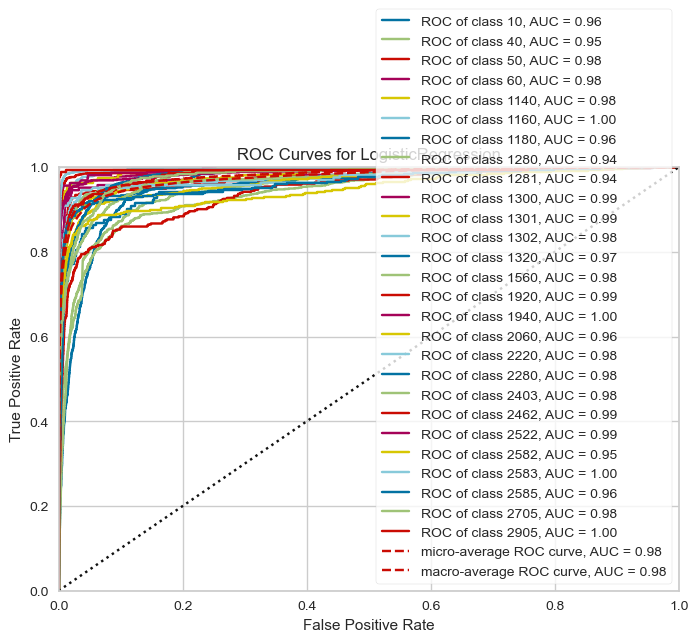

100%|██████████| 1/1 [14:27<00:00, 867.44s/it]

------------------------------------------------------------------------


In [13]:
run_models_cv({'Logestic Regression':lr_pip})

Logestic Regression: Mean Accuracy = 78.41%; Mean F1-macro = 77.07%; Mean recall-macro = 75.50%; Mean precision-macro = 79.41%

## RandomForestClassifier

In [ ]:
rfc_pip = Pipeline([('cv', CountVectorizer()), ('model', RandomForestClassifier())])

grid_params = {
    'model__max_depth': [50,150,300],
    'model__n_estimators': [50,100,200],
    'model__max_features': [20000, 100000, 150000]
}

rfkf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1) # With StratifiedKFold, the folds are made by preserving the percentage of samples for each class.


rfc_best = GridSearchCV(rfc_pip, grid_params, cv = rfkf, scoring='f1_macro', verbose = 3, return_train_score=True)\
    .fit(X_train, y_train)

print(f'Best hyperparameters are {rfc_best.best_params_}')
print(f'Best score is: {rfc_best.best_score_}')

In [ ]:
run_model(rfc_pip)

## Optimisation of selected model

* Based on metrics, Logestic Regression is picked up, now let's try to optimize it
* Metrics to beat : Mean Accuracy = 78.41%; Mean F1-macro = 77.07%; Mean recall-macro = 75.50%; Mean precision-macro = 79.41%

In [18]:
params = {"model__C": [0.001, 0.01, 0.1, 1, 10, 100]}

best_model = GridSearchCV(lr_pip, 
                                 param_grid = params, 
                                 cv=kf, 
                                 scoring='f1_macro',
                                 return_train_score=True, verbose = 3).fit(X_train, y_train)
best_model.best_score_  # print f1 score


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END model__C=0.001;, score=(train=0.523, test=0.509) total time=  11.1s
[CV 2/5] END model__C=0.001;, score=(train=0.523, test=0.512) total time=  12.1s
[CV 3/5] END model__C=0.001;, score=(train=0.525, test=0.505) total time=  11.0s
[CV 4/5] END model__C=0.001;, score=(train=0.523, test=0.510) total time=  12.1s
[CV 5/5] END model__C=0.001;, score=(train=0.524, test=0.507) total time=  15.6s
[CV 1/5] END .model__C=0.01;, score=(train=0.704, test=0.664) total time=  20.4s
[CV 2/5] END .model__C=0.01;, score=(train=0.705, test=0.658) total time=  17.4s
[CV 3/5] END .model__C=0.01;, score=(train=0.706, test=0.648) total time=  16.9s
[CV 4/5] END .model__C=0.01;, score=(train=0.704, test=0.657) total time=  16.8s
[CV 5/5] END .model__C=0.01;, score=(train=0.703, test=0.654) total time=  15.0s
[CV 1/5] END ..model__C=0.1;, score=(train=0.872, test=0.759) total time=  31.4s
[CV 2/5] END ..model__C=0.1;, score=(train=0.872,

0.7707053076561734

accuracy:  0.7949246349505417
classification_report: 
              precision    recall  f1-score   support

          10       0.42      0.61      0.50       623
          40       0.52      0.60      0.56       502
          50       0.77      0.74      0.76       336
          60       0.88      0.83      0.85       166
        1140       0.73      0.76      0.75       534
        1160       0.89      0.90      0.90       791
        1180       0.81      0.55      0.65       153
        1280       0.66      0.63      0.65       974
        1281       0.65      0.56      0.60       414
        1300       0.87      0.86      0.87      1009
        1301       0.96      0.84      0.90       161
        1302       0.86      0.78      0.82       498
        1320       0.83      0.79      0.81       648
        1560       0.84      0.82      0.83      1015
        1920       0.92      0.92      0.92       861
        1940       0.94      0.84      0.89       161
        2060       0.82    

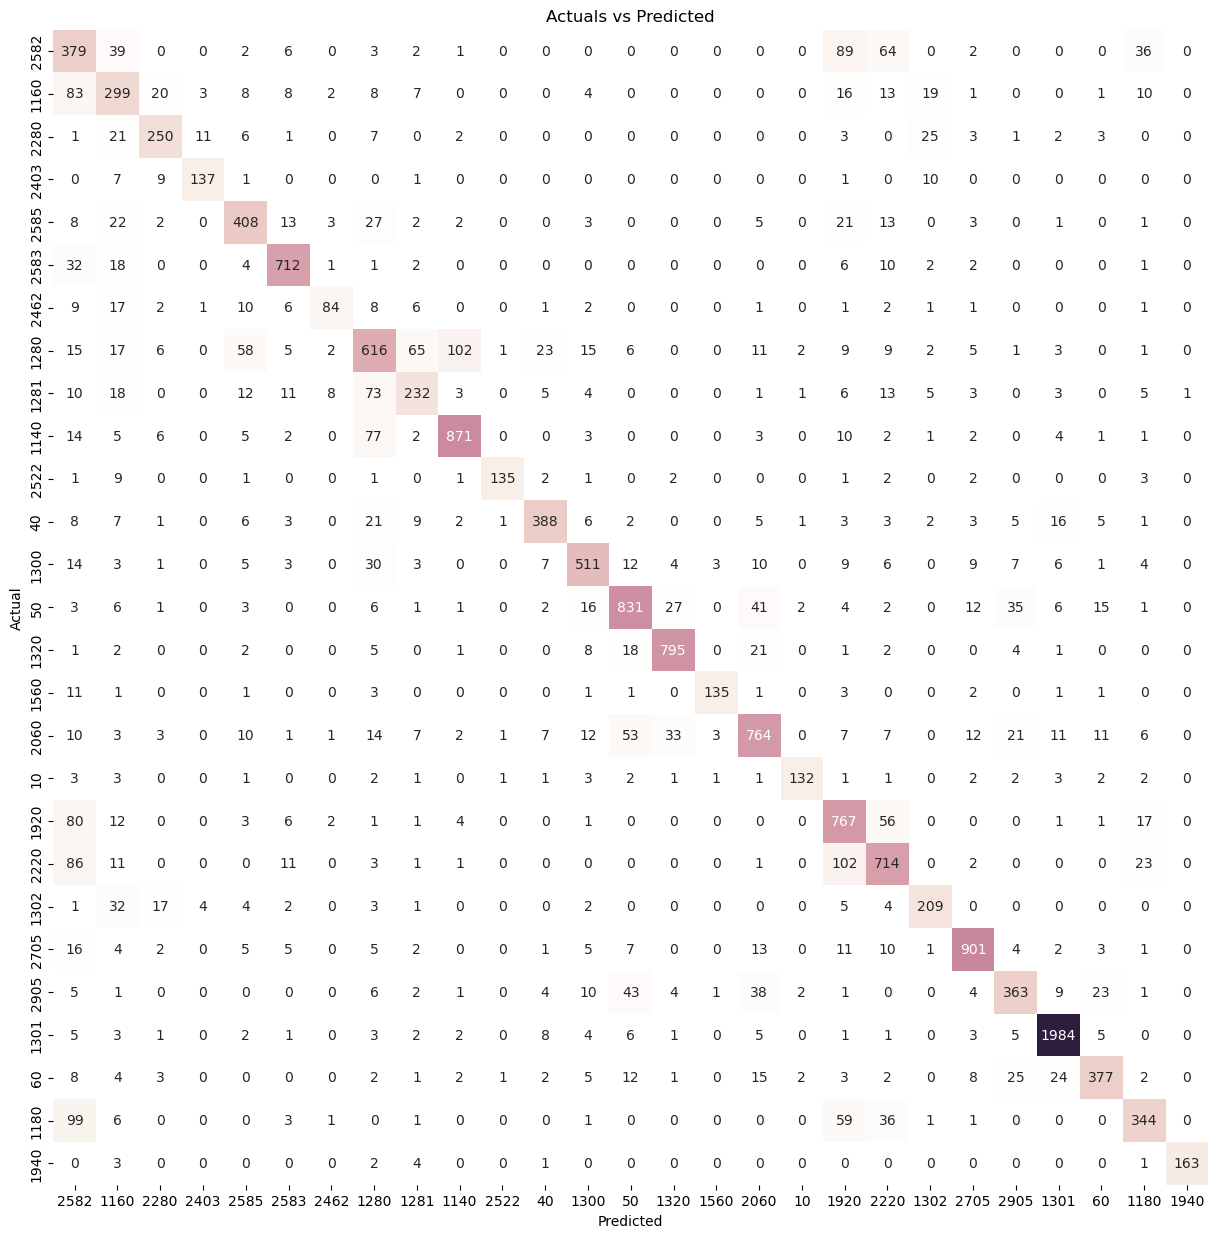

In [106]:
test_model(best_model.best_estimator_)